<a href="https://colab.research.google.com/github/davidfague/Model-Reduction-Methods/blob/main/Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rall's Theory

##Constraints:

Rall’s (D)3/2 rule : (Koch et al., 1991) (Koch & Segev: Methods in Neuronal modeling from synapses to networks)

There are 5 conditions that need to be satisfied for a nonsymmetrical branching tree to be able to be accurately represented by an equivalent cable. (These are assumptions made by neuron_reduce. The neuron_reduce method will be a weaker estimation when these constraints are not fully met.)

(1) Rm, Ri need to be the same in all branches.

(2) all terminal branches end with the same boundary condition (usually sealed end condition)

(3)all terminal branches end at the same electrotonic distance from the trunk origin.

(4) at every branch point the diameters need not be equal, but their 3/2 power sums must equal the 3/2 power of the parent branch diameter. (results in the same surface area as if there was no branching, and ensures the spread of current and voltage will yield the same voltage time course at all branch locations corresponding to the same electrotonic distance from the trunk origin)

(5) (if inputs are delivered to dendritic branch locations) proportional inputs must be delivered to all corresponding locations such that an equal input voltage time course would be generated at all electrotonically equivalent dendritic locations.


install dependencies

In [1]:
#dependencies for cell class
!pip install neuron

!pip install neuron_reduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.0/15.0 MB 57.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Define the cell

In [2]:
from typing_extensions import Self
from neuron import h,gui

import math
import numpy as np

from typing import Optional

from numpy.lib.function_base import select


class cell():
  '''
  class for storing useful cell information
  '''
  def __init__(self,soma_x=0,soma_y=0,soma_z=0,cell_template: Optional=None,vrest=-70):
    self.vrest=vrest
    self.soma_x=soma_x
    self.soma_y=soma_y
    self.soma_z=soma_z
    self.sections=[] # list of section class objects
    self.segments=[] # list of segment class objects
    self.nrn_sections=[] # list of nrn section objects
    self.nrn_segments=[] # list of nrn segment objects
    self.all = h.SectionList() # SectionList hoc object
    self.somatic = h.SectionList()
    self.apical = h.SectionList()
    self.basal = h.SectionList()
    self.axonal = h.SectionList() # list of axonal sections
    self.apic = []
    self.dend = []
    self.axon = []
    # self.soma = []
    if cell_template is not None:
      # print('develop to read cell into this format')
      #read cell_obj to extract exisiting morhpology
      self.read_cell(self,cell_template)

  def add_section(self,diameter,length,ang=0,dL=30,parentsection=None,name=str,sec_type='apic'):
    cell=self
    new_section=section(diameter,length,ang,dL,parentsection,name,cell,sec_type)
    cell.sections.append(new_section)
    return new_section
  
  def store_segment(self,seg,seg_id,x3d,y3d,z3d,length):
    '''creates a python segment object and stores it in cell.segments'''
    cell=self
    new_segment=segment(seg,seg_id,x3d,y3d,z3d,length)
    cell.segments.append(new_segment)
    return new_segment

  def read_cell(self,cell_template):
    for sec in cell_template.all:
      fullsecname = sec.name()
      sec_type = fullsecname.split(".")[1][:4]
      if sec_type=='dend':
        ang=np.random.uniform(low=90,high=270)
      else:
        ang=0
      parentsection=sec.parentseg().sec
      self.add_section(diameter=sec.diam,length=sec.L,ang=ang,parentsection=parentsection,name=sec.name(),sec_type=sec_type)


class section():
  def __init__(self,diameter,length,ang,dL,parentsection,name,cell,sec_type):
    self.segments=[]
    self.sec_type=sec_type
    ang=2*np.pi*(ang/360)
    print(name)
    new_section=h.Section(name=name) # nrn section object
    new_section.nseg = math.ceil(length / dL)
    self.sec=new_section #nrn section object
    new_section.L=length
    new_section.diam=diameter
    if parentsection is not None:
      # print(type(parentsection))
      new_section.connect(parentsection)
    # print(type(new_section.name()))
    if new_section.name()=='soma':
      self.sec_type='soma'
      self.origin=[cell.soma_x, cell.soma_y- diameter, cell.soma_z]
      # print(dir(cell))
      self.end=[cell.soma_x,cell.soma_y,cell.soma_z]
      # cell.soma=new_section
      soma=new_section
      self.id=0
      cell.soma=soma
      cell.somatic.append(soma)
    else:
      # print(type(parentsection))
      origin_x=parentsection.x3d(1)
      origin_y=parentsection.y3d(1)
      origin_z=parentsection.z3d(1)
      self.origin=[origin_x,origin_y,origin_z]
      end_x=origin_x+length * math.cos(ang)
      end_y=origin_y+length * math.sin(ang)
      end_z=origin_z
      self.end=[end_x,end_y,end_z]
      self.id=len(cell.sections)+1

    new_section.pt3dclear()
    new_section.pt3dadd(*self.origin,new_section.diam)
    new_section.pt3dadd(*self.end,new_section.diam)
    cell.nrn_sections.append(new_section)
    cell.all.append(new_section)
    if sec_type=='apic':
      cell.apical.append(new_section)
      cell.apic.append(new_section)
    else:
      cell.basal.append(new_section)
      cell.dend.apend(new_section)

    if new_section.nseg > 0:
        seg_length = new_section.L / new_section.nseg
    else:
        seg_length = new_section.L
    n3d = new_section.n3d()
    sec_x3d = np.empty(n3d)
    sec_y3d = np.empty(n3d)
    sec_z3d = np.empty(n3d)
    for i in range(n3d):
        sec_x3d[i]=new_section.x3d(i)
        sec_y3d[i]=new_section.y3d(i)
        sec_z3d[i]=new_section.z3d(i)
    for seg_index in range(new_section.nseg):
      seg_id=len(cell.segments) # get seg id of all segments
      seg_start = seg_index*seg_length # section length to seg start
      seg_mid = seg_start+seg_length/2 #section length to middle
      seg=new_section(seg_mid/new_section.L) # get nrn.segment object
      #travel seg_mid from section origin to section end
      seg_x3d=sec_x3d[0]+seg.x*(sec_x3d[-1]-sec_x3d[0])
      seg_y3d=sec_y3d[0]+seg.x*(sec_y3d[-1]-sec_y3d[0])
      seg_z3d=sec_z3d[0]+seg.x*(sec_z3d[-1]-sec_z3d[0])
      # print('seg_index:',seg_index,'|sec_x3d',sec_x3d,'|sec_y3d',sec_y3d,'|sec_z3d',sec_z3d,'|seg_x3d',seg_x3d,'|seg_y3d',seg_y3d,'|seg_z3d',seg_z3d,'|seg_length',seg_length)
      cell.nrn_segments.append(seg)
      new_seg=cell.store_segment(seg,seg_id,seg_x3d,seg_y3d,seg_z3d,seg_length)
      self.segments.append(new_seg)

class segment():
  def __init__(self,seg,seg_id,x3d,y3d,z3d,length):
    self.seg=seg
    self.diam=seg.diam,
    self.x3d=x3d
    self.y3d=y3d
    self.z3d=z3d
    self.loc=seg.x
    self.length=length
    self.sec=seg.sec
    # self.soma_elec_dist=soma_elec_dist


def calculate_rall_diameter(trunk_diam,nbranch):
  branch_diam=(trunk_diam**(3/2)/nbranch)**(2/3)
  return branch_diam








rall_cell = cell()
soma = rall_cell.add_section(diameter=10,length=10,name='soma')
trunk = rall_cell.add_section(name='trunk',diameter=10,length=1000,ang=0,parentsection=soma.sec)
nbranch=2
branches=[]

def calculate_rall_diameter(trunk_diam,nbranch):
  branch_diam=(trunk_diam**(3/2)/nbranch)**(2/3)
  return branch_diam

def add_branches(cell,nbranch,parentsection,ang):
  '''
  WIP
  build branches using rall diameter
  '''
  for branch in nbranch:
    ang = 2 * math.pi / nbranch
    cell.add_section(name='branch'+len(branches),diameter=calculate_rall_diameter(trunk_diam=parentsection.diam,nbranch=nbranch),ang=ang)


branch1 = rall_cell.add_section(name='branch1',diameter=calculate_rall_diameter(trunk_diam=10,nbranch=2),length=200,ang=45,parentsection=trunk.sec)
branch2 = rall_cell.add_section(name='branch2',diameter=calculate_rall_diameter(trunk_diam=10,nbranch=2),length=200,ang=-45,parentsection=trunk.sec)

soma
trunk
branch1
branch2


#Neuron_reduce: (Segev Lab, Oren Amsalem)  (nature.com)

Replaces entire dendritic tree with a single equivalent cable, mapping synapses and conductances by matching transfer impedance to the soma. 

D and L of cable are chosen by two constraints: 

(1)	The magnitude of the transfer impedance from the cable’s distal sealed end to its proximal end is identical to the magnitude of the transfer impedance from the electrotonically most distal dendritic tip to the soma in the original dendrite.

(2)	The magnitude of the input impedance at the proximal end of the cable is identical to that of the original stem dendrite (when decoupled from the soma).


Reduce the dendritic tree

In [3]:
import os
import pandas as pd

!git clone https://github.com/davidfague/Model-Reduction-Methods
%cd Model-Reduction-Methods/

mechanisms_path = 'mechanisms'  # need to compile the folder first
# geometry_file='rall_model.csv' #for when geometry file can be used
tstop = 1000  # ms simulation duration
dt = 0.1  # ms. does not allow change

h.load_file('stdrun.hoc')
#h.nrn_load_dll(os.path.join(mechanisms_path,'nrnmech.dll'))  # running this line more than once might crash the kernel
h.nrn_load_dll(os.path.join(mechanisms_path,'x86_64/.libs/libnrnmech.so'))  # use this line instead in Linux
# geo_standard = pd.read_csv(geometry_file,index_col='id')
h.tstop = tstop
h.dt = dt
h.steps_per_ms = 1/h.dt

Cloning into 'Model-Reduction-Methods'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 186 (delta 69), reused 157 (delta 56), pack-reused 0
Receiving objects: 100% (186/186), 981.25 KiB | 7.11 MiB/s, done.
Resolving deltas: 100% (69/69), done.
/content/Model-Reduction-Methods


In [4]:
%ls

Create_NR_Geometry.ipynb  mechanisms/  README.md         test_neuron_reduce/
Example.ipynb             Notebooks/   stylized_module/  utils/


In [5]:
from neuron_reduce.subtree_reductor_func import subtree_reductor
complex_cell = cell(soma_y=-300)
# print(dir(complex_cell))
soma = complex_cell.add_section(diameter=10,length=10,name='soma')
trunk = complex_cell.add_section(name='trunk',diameter=10,length=1000,ang=0,parentsection=soma.sec)
branch1 = complex_cell.add_section(name='branch1',diameter=6.3,length=200,ang=45,parentsection=trunk.sec)
branch2 = complex_cell.add_section(name='branch2',diameter=6.3,length=200,ang=-45,parentsection=trunk.sec)

gl = 0.0003

for sec in complex_cell.nrn_sections:
    if sec.name()=='soma':
      sec.cm= 1
    else:
      sec.cm = 2.0
    print(sec.name())
    sec.Ra = 100
    sec.insert('pas')
    sec.g_pas = gl
    sec.e_pas = complex_cell.vrest
    sec.insert('hh')
    sec.insert('NaTa_t')  # Sodium channel
    sec.insert('SKv3_1')  # Potassium channel
    sec.insert('Ca_HVA')
    sec.insert('Ca_LVAst')
    sec.insert('CaDynamics_E2')
    sec.insert('Ih')
    sec.insert('SK_E2')
    sec.insert('K_Tst')
    sec.insert('K_Pst')
    sec.insert('Nap_Et2')
    sec.ena = 50
    sec.ek = -85
# for i,entry in enumerate(self.biophys_entries):
#   for sec in self.get_sec_by_id(self.grp_ids[entry[0]]):
#     setattr(sec,entry[1],self.biophys[i])

reduced_rall_cell=subtree_reductor(complex_cell,synapses_list=[],netcons_list=[],reduction_frequency=0)
reduced_rall_cell=cell(template=reduced_rall_cell) #create cell object from above class and template to store properties

NEURON: subscript < 1 dend
 near line 1
 {create dend[0]}
                 ^
        execute("create dend[0]", 

soma
trunk
branch1
branch2
soma
trunk
branch1
branch2


model[0])


Exception: ignored

Plot morphologies

In [ ]:
plot_morphology(complex_cell)


In [ ]:
print(complex_cell.soma.y3d(0))

In [ ]:
import matplotlib.pyplot as plt
def plot_morphology(cell_list,savename=None):
  if type(cell_list) is not list:
    cell_list=[cell_list]
  plt.figure(figsize=(10,4))
  for cell in cell_list:
    for sec in cell.sections:
      print(sec.sec.name())
      x3ds=[]
      y3ds=[]
      z3ds=[]
      # print(sec.sec.diam)
      for seg in sec.segments:
        # print('seg.x3d', seg.x3d)
        # print('seg.y3d', seg.y3d)
        # print('seg.z3d', seg.z3d)
        x3ds.append(seg.x3d)
        y3ds.append(seg.y3d)
        z3ds.append(seg.z3d)
        # plt.plot(seg.x3d,seg.y3d,seg.z3d,
        #          color='k',
        #          linewidth=2*sec.sec.diam)
      plt.plot(x3ds,y3ds,z3ds,color='k',linewidth=2*sec.sec.diam)
    # plt.scatter(cell.segments[0].x3d,cell.segments[0].y3d,color='k',s=cell.soma.diam)
  if savename is not None:
    plt.savefig(savename)

plot_morphology(rall_cell,'rall_tree_morphology.svg')
plot_morphology(reduced_rall_cell,'rall_cable_morphology.svg')
plot_morphology([rall_cell,reduced_rall_cell],'reduction_comparison.svg')

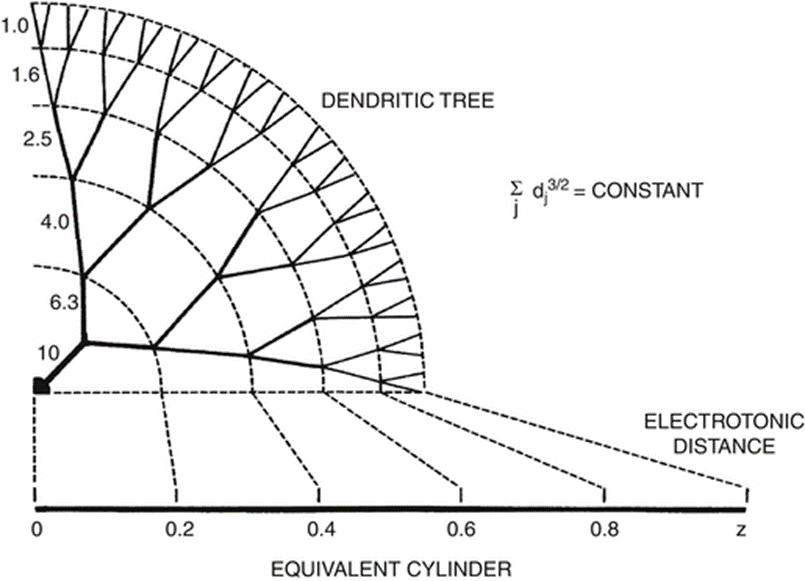

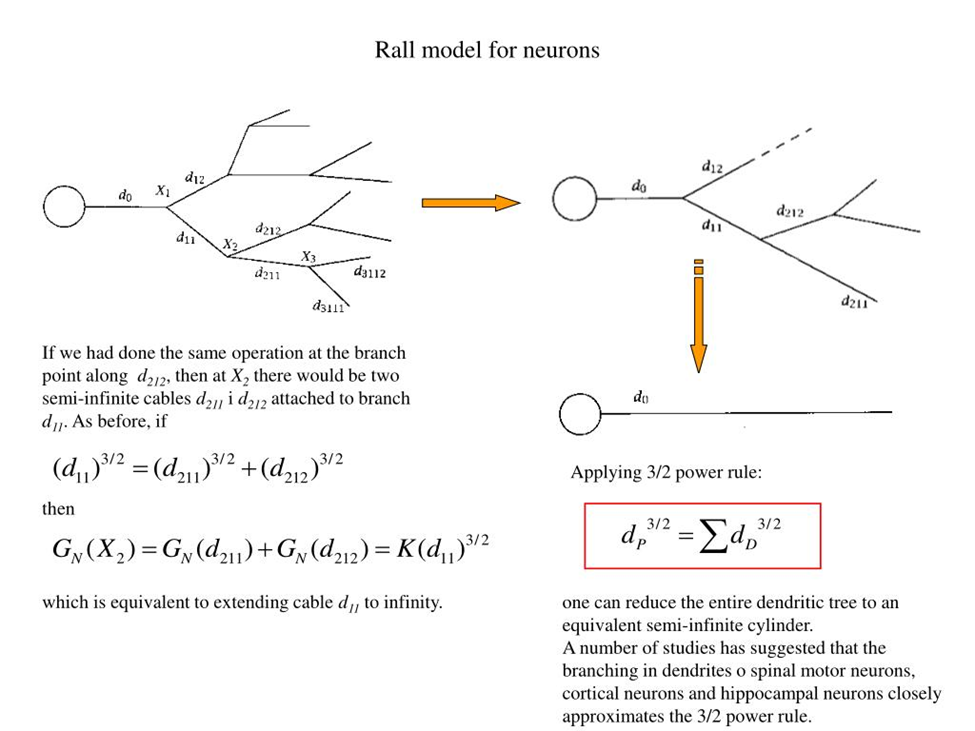

#Neuron_reduce_expanded: (Nair Lab)

Uses Rall’s constraints to revert single equivalent cylinder into a dendritic tree with specified number of branches and branching point. Part of the cable remains as the trunk. The other part of the cable is replaced with branches.

Constraint 4 is used to determine diameters. Any branch diameters can be chosen such that 〖d_cable〗^(3/2)=∑〖〖(d〗_branch〗^(3/2)). However, same diameter may be preferred for applying Constraint 5.

Then the branch lengths are chosen so that each branch has the same electrotonic distance as the deleted portion of the cable, or so that the magnitude of the transfer impedance from the distal tip of the cable to the proximal end is the same as the transfer impedance from the distal tip of each branch to the proximal end of the trunk. (equation to come)

Constraint 5 is used to assign conductances and synapses to the new branches. Location of each synapse and conductance will swap from cable to each of the electrotonically equivalent branch locations (duplicated for each branch). gmax must be adjusted so that the same voltage time course is seen after expansion. (equation to come) (voltage time course seen at dendritic locations will be dependent on input resistance, which will vary with diameter.)
